In [1]:
import numpy as np # linear algebra
import pandas as pd 

In [2]:
# dowload dataset
data1= pd.read_csv('twitter/shorttextpreprocessedtest.csv')
data2= pd.read_csv('twitter/shorttextpreprocessedtrain.csv')
data3= pd.read_csv('twitter/newdatasetwithcoviddata.csv')

In [3]:
data=pd.concat([data1,data2,data3]).reset_index(drop=True)

In [4]:
data.shape

(193604, 2)

In [5]:
data.head()

text  label
0  torrance named europe s fifth ryder cup vice c...      0
1  i have never asked for a single earmark pork b...      0
2  hitting the media center to recap strong debat...      0
3  creflo dollar needed a million gulfstream g to...      0
4                                                NaN      0

In [6]:
## Data Preparation
data = data[data['text'].notna()]


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

import nltk 
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/administrator/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/administrator/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
# Let's do some statistics of the text columns
txt_len = data.text.str.split().str.len()
txt_len.describe()

count    193445.000000
mean         14.685156
std           5.930034
min           1.000000
25%          10.000000
50%          15.000000
75%          19.000000
max          97.000000
Name: text, dtype: float64

<AxesSubplot:xlabel='label', ylabel='count'>

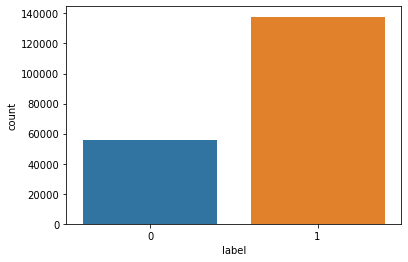

In [9]:
# Class Distribution
# 1: Unreliable
# 2: Reliable
sns.countplot(x='label', data= data)

In [10]:
print(data.label.value_counts())
print()
print(round(data.label.value_counts(normalize=True),2)*100)

1    137796
0     55649
Name: label, dtype: int64

1    71.0
0    29.0
Name: label, dtype: float64


In [11]:
data.isnull().sum()

text     0
label    0
dtype: int64

In [12]:
column_n = [ 'text', 'label']

categorical_features = []
target_col = ['label']
text_f = ['text']

In [13]:
# cleaning
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer
from collections import Counter

ps = PorterStemmer()
wnl = nltk.stem.WordNetLemmatizer()

stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)


# impute null values with none
def null_process(feature_df):
    for col in text_f:
        feature_df.loc[feature_df[col].isnull(),col] = "None"
    return feature_df

# clean_data
def clean_dataset(df):   
    #impute null value
    df = null_process(df)
    
    return df

# Cleaning text from unused characters
def clean_text(text):
    text = str(text).replace(r'http[\w:/\.]+', ' ')  # removing urls
    text = str(text).replace(r'[^\.\w\s]', ' ')  # remove everything but characters and punctuation
    text = str(text).replace('[^a-zA-Z]', ' ')
    text = str(text).replace(r'\s\s+', ' ')
    text = text.lower().strip()
    #text = ' '.join(text)    
    return text

## Nltk Preprocessing include:
# Stop words, Stemming and Lemmetization
# For our project we use only Stop word removal
def nltk_preprocess(text):
    text = clean_text(text)
    wordlist = re.sub(r'[^\w\s]', '', text).split()
    text = ' '.join([wnl.lemmatize(word) for word in wordlist if word not in stopwords_dict])
    return  text

In [14]:
df = clean_dataset(data)
df['text'] = df.text.apply(nltk_preprocess)


In [15]:
df.head()

text  label
0  torrance named europe fifth ryder cup vice cap...      0
1  never asked single earmark pork barrel project...      0
2  hitting medium center recap strong debate perf...      0
3  creflo dollar needed million gulfstream g carr...      0
5       wednesday morning meal trump win electionday      0

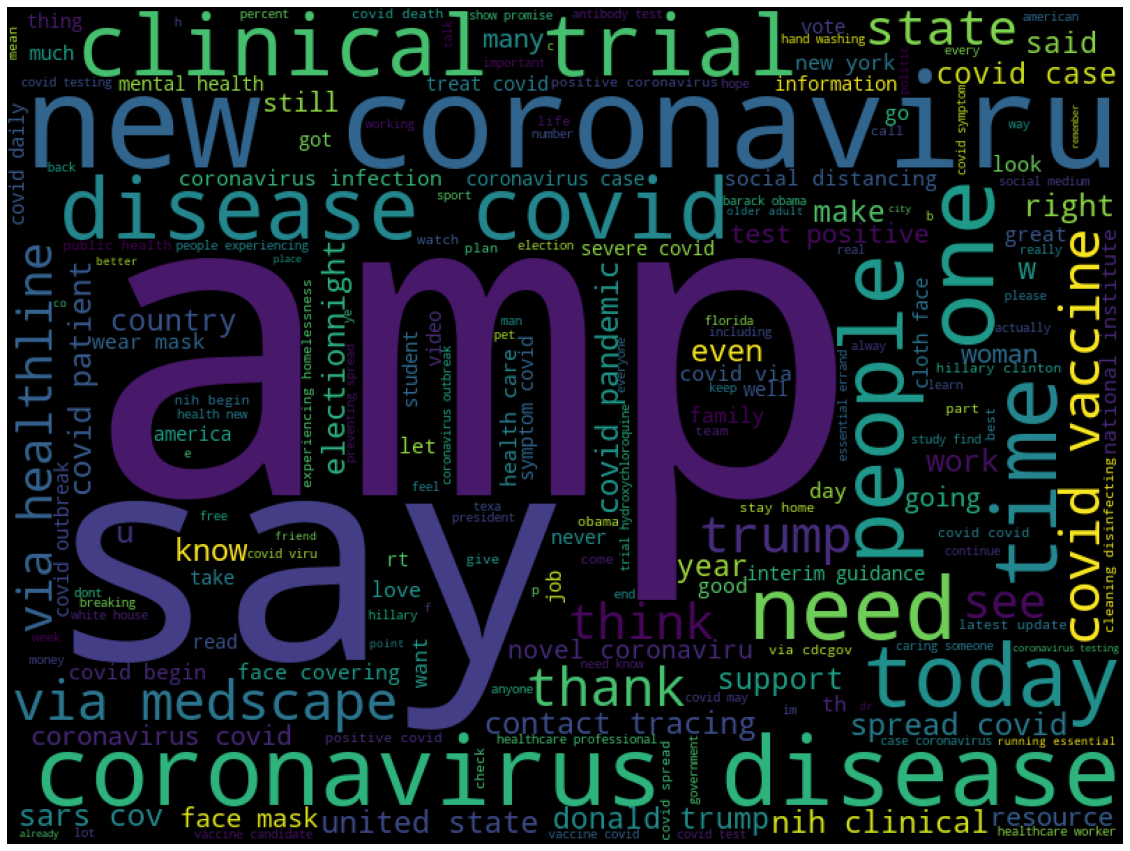

In [16]:
from wordcloud import WordCloud, STOPWORDS

# initialize the word cloud
wordcloud = WordCloud(background_color='black', width=800, height=600)
# generate the word cloud
text_cloud = wordcloud.generate(" ".join(df['text']))
# plotting the word cloud
plt.figure(figsize=(20,30))
plt.imshow(text_cloud)
plt.axis('off')
plt.show()

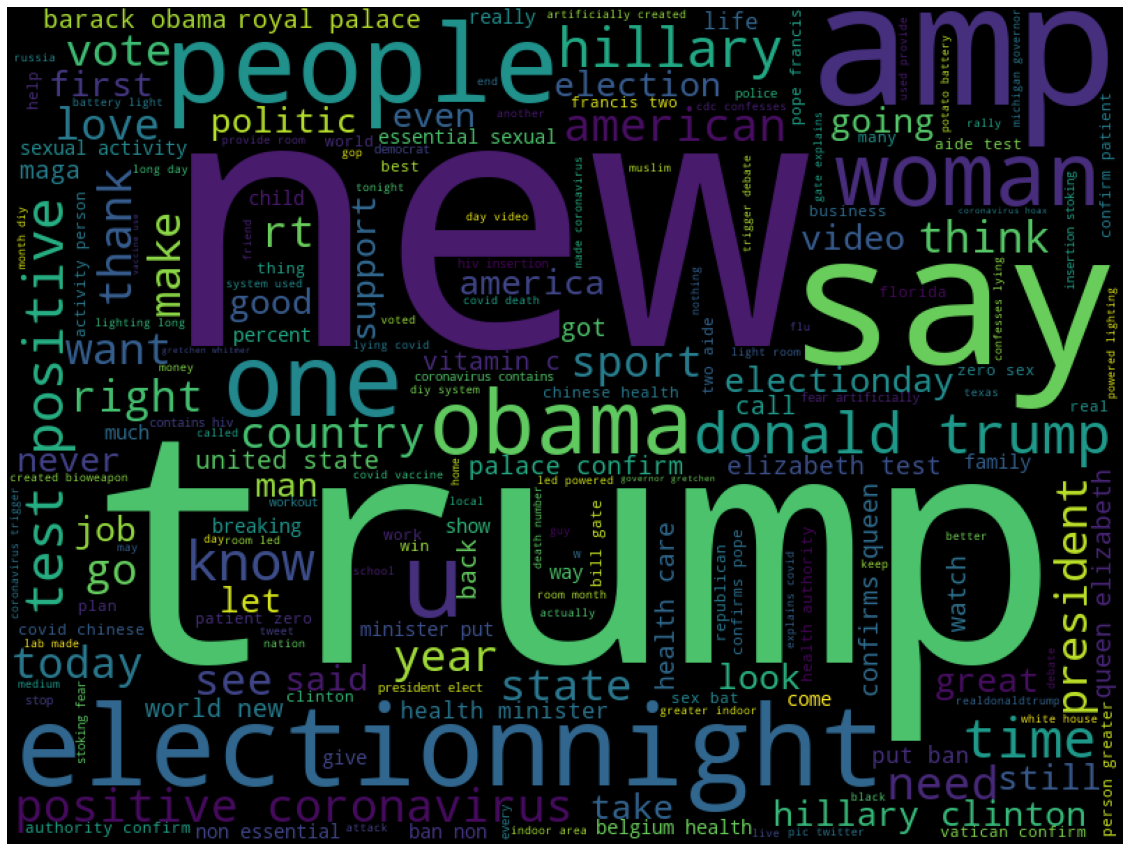

In [17]:
# reliable news (0)
reliable_news = " ".join(df[df['label']==0]['text'])
wc = wordcloud.generate(reliable_news)
plt.figure(figsize=(20,30))
plt.imshow(wc)
plt.axis('off')
plt.show()

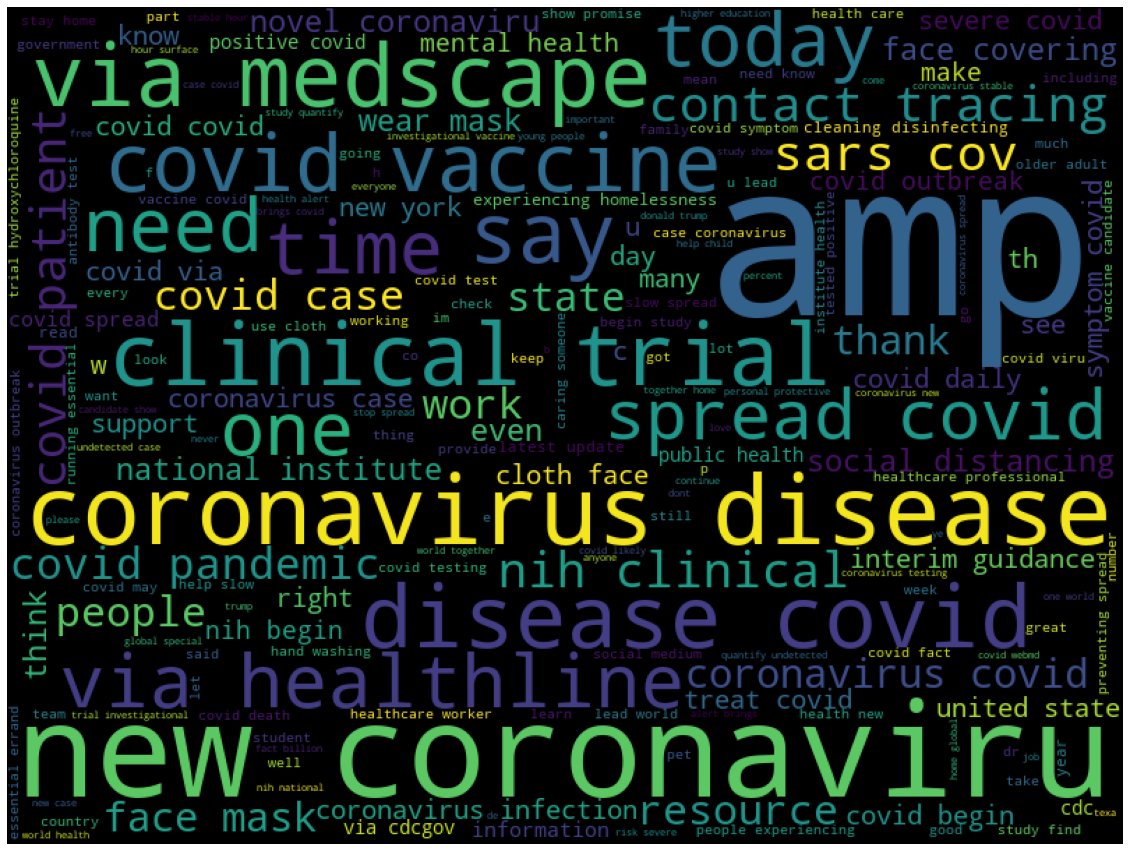

In [18]:
# unreliable news (1)
unreliable_news  = ' '.join(df[df['label']==1]['text'])
wc= wordcloud.generate(unreliable_news)
plt.figure(figsize=(20,30))
plt.imshow(wc)
plt.axis('off')
plt.show()

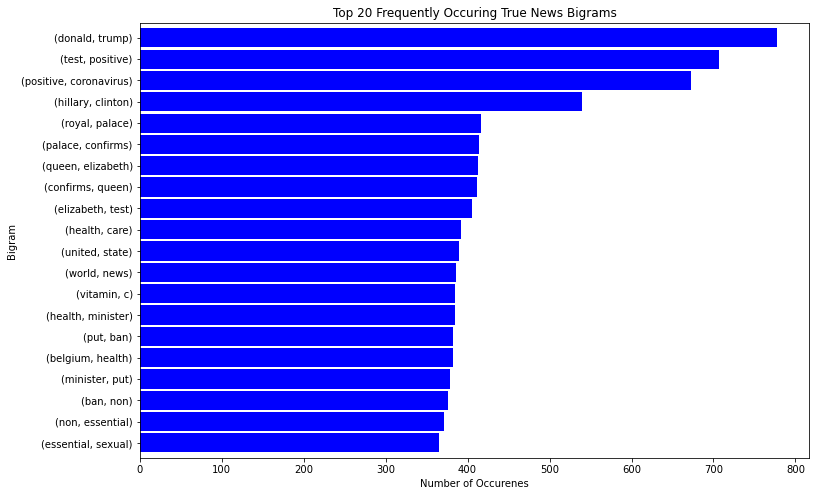

In [19]:
# Bigram 

def plot_top_ngrams(corpus, title, ylabel, xlabel="Number of Occurenes", n =2):
    true_b = (pd.Series(nltk.ngrams(corpus.split(), n)).value_counts())[:20]
    true_b.sort_values().plot.barh(color='blue', width=.9, figsize=(12,8))
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()
    
    
plot_top_ngrams(reliable_news, "Top 20 Frequently Occuring True News Bigrams", "Bigram", n=2)

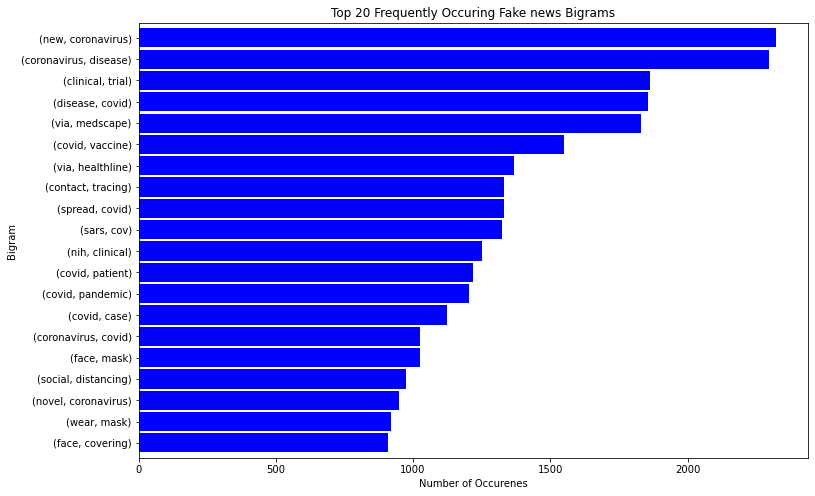

In [20]:
plot_top_ngrams(unreliable_news, 'Top 20 Frequently Occuring Fake news Bigrams', "Bigram", n=2)

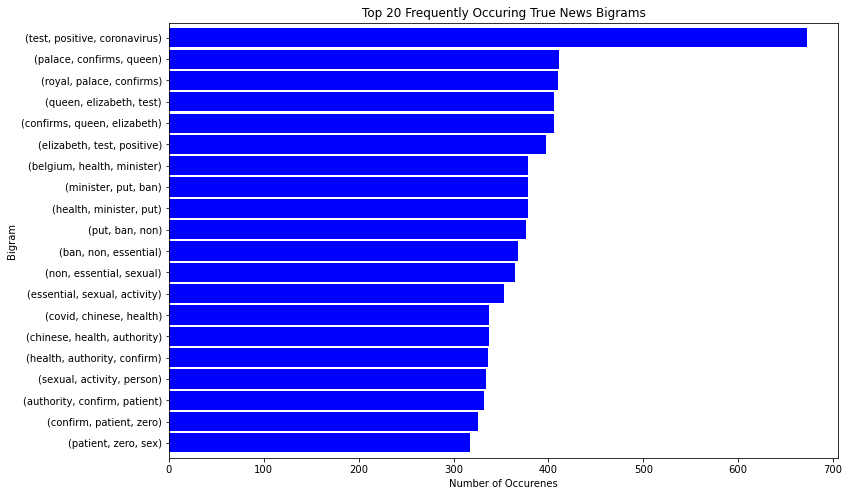

In [21]:
# Trigram
plot_top_ngrams(reliable_news, "Top 20 Frequently Occuring True News Bigrams", "Bigram", n=3)

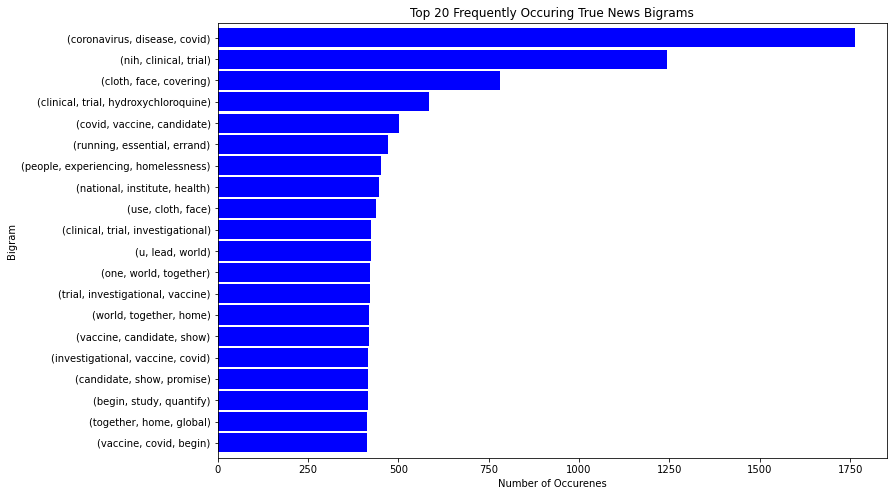

In [22]:
plot_top_ngrams(unreliable_news, "Top 20 Frequently Occuring True News Bigrams", "Bigram", n=3)

In [23]:
!pip install transformers

In [24]:
import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import random

In [25]:
def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf

        tf.random.set_seed(seed)

set_seed(123)

In [26]:
model_name = "bert-base-uncased"
max_length= 512

In [27]:
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

In [28]:
data.head()

text  label
0  torrance named europe fifth ryder cup vice cap...      0
1  never asked single earmark pork barrel project...      0
2  hitting medium center recap strong debate perf...      0
3  creflo dollar needed million gulfstream g carr...      0
5       wednesday morning meal trump win electionday      0

In [29]:
## Data Preparation
data = data[data['text'].notna()]


In [30]:
def prepare_data(df, test_size=0.2, include_title=True, include_author=True):
    texts = []
    labels = []
    
    for i in range(len(df)):
        text = df['text'].iloc[i]
        label = df['label'].iloc[i]
        
        if text and label in [0,1]:
            texts.append(text)
            labels.append(label)
            
    return train_test_split(texts, labels, test_size=test_size)

train_texts, valid_texts, train_labels, valid_labels = prepare_data(data)

In [31]:
print(len(train_texts), len(train_labels))
print(len(valid_texts), len(valid_labels))

154673 154673
38669 38669


In [32]:
# tokenizing the dataset
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)

In [33]:
# converting the encoding into a PyTorch datset
class NewsGroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor([self.labels[idx]])
        return item
    
    def __len__(self):
        return len(self.labels)
    
# convert tokenize data into torch dataset
train_dataset = NewsGroupsDataset(train_encodings, train_labels)
valid_dataset = NewsGroupsDataset(valid_encodings, valid_labels)

In [34]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [42]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
def computer_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [43]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=10,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=200,               # log & save weights each logging_steps
    save_steps=200,
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)

using `logging_steps` to initialize `eval_steps` to 200
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [44]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=computer_metrics,
)

In [45]:
trainer.train()


/home/administrator/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 154673
  Num Epochs = 1
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 20
  Gradient Accumulation steps = 1
  Total optimization steps = 7734
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.165
Attempted to log scalar metric learning_rate:
4.9345035368090126e-05
Attempted to log scalar metric epoch:
0.03
Attempted to log scalar metric eval_loss:
0.5660737156867981
Attempted to log scalar metric eval_accuracy:
0.8709043419793633
Attempted to log scalar metric eval_f1:
0.9066182797710353
Attempted to log scalar metric eval_precision:
0.9321101623201785
Attempted to log scalar metric eval_recall:
0.8824836125273124
Attempted to log scalar metric eval_runtime:
100.8844
Attempted to log scalar metric eval_samples_per_second:
383.3
Attempted to log scalar metric eval_steps_per_second:
9.585
Attempted to log scalar metric epoch:
0.03


Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json
Model weights saved in ./results/checkpoint-200/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.3072
Attempted to log scalar metric learning_rate:
4.803510610427037e-05
Attempted to log scalar metric epoch:
0.05
Attempted to log scalar metric eval_loss:
0.23988474905490875
Attempted to log scalar metric eval_accuracy:
0.8975148051410691
Attempted to log scalar metric eval_f1:
0.9268832678363869
Attempted to log scalar metric eval_precision:
0.9393440783815116
Attempted to log scalar metric eval_recall:
0.9147487254187909
Attempted to log scalar metric eval_runtime:
100.0906
Attempted to log scalar metric eval_samples_per_second:
386.34
Attempted to log scalar metric eval_steps_per_second:
9.661
Attempted to log scalar metric epoch:
0.05


Saving model checkpoint to ./results/checkpoint-400
Configuration saved in ./results/checkpoint-400/config.json
Model weights saved in ./results/checkpoint-400/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.259
Attempted to log scalar metric learning_rate:
4.672517684045062e-05
Attempted to log scalar metric epoch:
0.08
Attempted to log scalar metric eval_loss:
0.21229875087738037
Attempted to log scalar metric eval_accuracy:
0.9098244071478445
Attempted to log scalar metric eval_f1:
0.9365503939443566
Attempted to log scalar metric eval_precision:
0.935920282212605
Attempted to log scalar metric eval_recall:
0.9371813546977422
Attempted to log scalar metric eval_runtime:
102.9346
Attempted to log scalar metric eval_samples_per_second:
375.666
Attempted to log scalar metric eval_steps_per_second:
9.394
Attempted to log scalar metric epoch:
0.08


Saving model checkpoint to ./results/checkpoint-600
Configuration saved in ./results/checkpoint-600/config.json
Model weights saved in ./results/checkpoint-600/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.2493
Attempted to log scalar metric learning_rate:
4.5415247576630866e-05
Attempted to log scalar metric epoch:
0.1
Attempted to log scalar metric eval_loss:
0.20049017667770386
Attempted to log scalar metric eval_accuracy:
0.9111691535855595
Attempted to log scalar metric eval_f1:
0.9384904646790222
Attempted to log scalar metric eval_precision:
0.9231988726440021
Attempted to log scalar metric eval_recall:
0.9542971595047341
Attempted to log scalar metric eval_runtime:
99.3567
Attempted to log scalar metric eval_samples_per_second:
389.194
Attempted to log scalar metric eval_steps_per_second:
9.733
Attempted to log scalar metric epoch:
0.1


Saving model checkpoint to ./results/checkpoint-800
Configuration saved in ./results/checkpoint-800/config.json
Model weights saved in ./results/checkpoint-800/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.2339
Attempted to log scalar metric learning_rate:
4.410531831281111e-05
Attempted to log scalar metric epoch:
0.13
Attempted to log scalar metric eval_loss:
0.2294282615184784
Attempted to log scalar metric eval_accuracy:
0.9126949235821976
Attempted to log scalar metric eval_f1:
0.9392609118059803
Attempted to log scalar metric eval_precision:
0.928205675272029
Attempted to log scalar metric eval_recall:
0.9505826656955572
Attempted to log scalar metric eval_runtime:
99.8797
Attempted to log scalar metric eval_samples_per_second:
387.156
Attempted to log scalar metric eval_steps_per_second:
9.682
Attempted to log scalar metric epoch:
0.13


Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.2281
Attempted to log scalar metric learning_rate:
4.279538904899136e-05
Attempted to log scalar metric epoch:
0.16
Attempted to log scalar metric eval_loss:
0.19253292679786682
Attempted to log scalar metric eval_accuracy:
0.9168067444205953
Attempted to log scalar metric eval_f1:
0.9408346054107738
Attempted to log scalar metric eval_precision:
0.9503957195407424
Attempted to log scalar metric eval_recall:
0.9314639475600874
Attempted to log scalar metric eval_runtime:
103.9698
Attempted to log scalar metric eval_samples_per_second:
371.925
Attempted to log scalar metric eval_steps_per_second:
9.301
Attempted to log scalar metric epoch:
0.16


Saving model checkpoint to ./results/checkpoint-1200
Configuration saved in ./results/checkpoint-1200/config.json
Model weights saved in ./results/checkpoint-1200/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.2102
Attempted to log scalar metric learning_rate:
4.1485459785171606e-05
Attempted to log scalar metric epoch:
0.18
Attempted to log scalar metric eval_loss:
0.20591522753238678
Attempted to log scalar metric eval_accuracy:
0.9214357754273449
Attempted to log scalar metric eval_f1:
0.9443854574744627
Attempted to log scalar metric eval_precision:
0.949495693145844
Attempted to log scalar metric eval_recall:
0.9393299344501093
Attempted to log scalar metric eval_runtime:
100.0623
Attempted to log scalar metric eval_samples_per_second:
386.449
Attempted to log scalar metric eval_steps_per_second:
9.664
Attempted to log scalar metric epoch:
0.18


Saving model checkpoint to ./results/checkpoint-1400
Configuration saved in ./results/checkpoint-1400/config.json
Model weights saved in ./results/checkpoint-1400/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.2058
Attempted to log scalar metric learning_rate:
4.017553052135185e-05
Attempted to log scalar metric epoch:
0.21
Attempted to log scalar metric eval_loss:
0.20778493583202362
Attempted to log scalar metric eval_accuracy:
0.9217978225451913
Attempted to log scalar metric eval_f1:
0.9449140192363742
Attempted to log scalar metric eval_precision:
0.9453273071876367
Attempted to log scalar metric eval_recall:
0.9445010924981792
Attempted to log scalar metric eval_runtime:
98.9787
Attempted to log scalar metric eval_samples_per_second:
390.68
Attempted to log scalar metric eval_steps_per_second:
9.77
Attempted to log scalar metric epoch:
0.21


Saving model checkpoint to ./results/checkpoint-1600
Configuration saved in ./results/checkpoint-1600/config.json
Model weights saved in ./results/checkpoint-1600/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.2049
Attempted to log scalar metric learning_rate:
3.88656012575321e-05
Attempted to log scalar metric epoch:
0.23
Attempted to log scalar metric eval_loss:
0.19717440009117126
Attempted to log scalar metric eval_accuracy:
0.9186169800098269
Attempted to log scalar metric eval_f1:
0.9441020266789818
Attempted to log scalar metric eval_precision:
0.9215298727417733
Attempted to log scalar metric eval_recall:
0.9678077203204661
Attempted to log scalar metric eval_runtime:
97.5514
Attempted to log scalar metric eval_samples_per_second:
396.396
Attempted to log scalar metric eval_steps_per_second:
9.913
Attempted to log scalar metric epoch:
0.23


Saving model checkpoint to ./results/checkpoint-1800
Configuration saved in ./results/checkpoint-1800/config.json
Model weights saved in ./results/checkpoint-1800/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.2007
Attempted to log scalar metric learning_rate:
3.7555671993712346e-05
Attempted to log scalar metric epoch:
0.26
Attempted to log scalar metric eval_loss:
0.19636863470077515
Attempted to log scalar metric eval_accuracy:
0.9226770798313895
Attempted to log scalar metric eval_f1:
0.944535133931884
Attempted to log scalar metric eval_precision:
0.9626058681185723
Attempted to log scalar metric eval_recall:
0.9271303714493809
Attempted to log scalar metric eval_runtime:
97.8514
Attempted to log scalar metric eval_samples_per_second:
395.181
Attempted to log scalar metric eval_steps_per_second:
9.882
Attempted to log scalar metric epoch:
0.26


Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.1872
Attempted to log scalar metric learning_rate:
3.624574272989259e-05
Attempted to log scalar metric epoch:
0.28
Attempted to log scalar metric eval_loss:
0.17771483957767487
Attempted to log scalar metric eval_accuracy:
0.9309007215081848
Attempted to log scalar metric eval_f1:
0.9514852204226887
Attempted to log scalar metric eval_precision:
0.948797798377752
Attempted to log scalar metric eval_recall:
0.9541879096868172
Attempted to log scalar metric eval_runtime:
97.5464
Attempted to log scalar metric eval_samples_per_second:
396.416
Attempted to log scalar metric eval_steps_per_second:
9.913
Attempted to log scalar metric epoch:
0.28


Saving model checkpoint to ./results/checkpoint-2200
Configuration saved in ./results/checkpoint-2200/config.json
Model weights saved in ./results/checkpoint-2200/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.1922
Attempted to log scalar metric learning_rate:
3.493581346607284e-05
Attempted to log scalar metric epoch:
0.31
Attempted to log scalar metric eval_loss:
0.24678701162338257
Attempted to log scalar metric eval_accuracy:
0.9249528045721379
Attempted to log scalar metric eval_f1:
0.9480914392015167
Attempted to log scalar metric eval_precision:
0.9316599873444421
Attempted to log scalar metric eval_recall:
0.9651128914785142
Attempted to log scalar metric eval_runtime:
100.1791
Attempted to log scalar metric eval_samples_per_second:
385.999
Attempted to log scalar metric eval_steps_per_second:
9.653
Attempted to log scalar metric epoch:
0.31


Saving model checkpoint to ./results/checkpoint-2400
Configuration saved in ./results/checkpoint-2400/config.json
Model weights saved in ./results/checkpoint-2400/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.2031
Attempted to log scalar metric learning_rate:
3.362588420225308e-05
Attempted to log scalar metric epoch:
0.34
Attempted to log scalar metric eval_loss:
0.16694919764995575
Attempted to log scalar metric eval_accuracy:
0.9293490910031291
Attempted to log scalar metric eval_f1:
0.9497498528546204
Attempted to log scalar metric eval_precision:
0.9594916010108518
Attempted to log scalar metric eval_recall:
0.940203932993445
Attempted to log scalar metric eval_runtime:
99.8045
Attempted to log scalar metric eval_samples_per_second:
387.447
Attempted to log scalar metric eval_steps_per_second:
9.689
Attempted to log scalar metric epoch:
0.34


Saving model checkpoint to ./results/checkpoint-2600
Configuration saved in ./results/checkpoint-2600/config.json
Model weights saved in ./results/checkpoint-2600/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.1825
Attempted to log scalar metric learning_rate:
3.2315954938433326e-05
Attempted to log scalar metric epoch:
0.36
Attempted to log scalar metric eval_loss:
0.1728910505771637
Attempted to log scalar metric eval_accuracy:
0.9324006309964054
Attempted to log scalar metric eval_f1:
0.9527476500361534
Attempted to log scalar metric eval_precision:
0.945908111988514
Attempted to log scalar metric eval_recall:
0.959686817188638
Attempted to log scalar metric eval_runtime:
100.0929
Attempted to log scalar metric eval_samples_per_second:
386.331
Attempted to log scalar metric eval_steps_per_second:
9.661
Attempted to log scalar metric epoch:
0.36


Saving model checkpoint to ./results/checkpoint-2800
Configuration saved in ./results/checkpoint-2800/config.json
Model weights saved in ./results/checkpoint-2800/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.1804
Attempted to log scalar metric learning_rate:
3.100602567461357e-05
Attempted to log scalar metric epoch:
0.39
Attempted to log scalar metric eval_loss:
0.16727760434150696
Attempted to log scalar metric eval_accuracy:
0.9318316998112183
Attempted to log scalar metric eval_f1:
0.952439376443418
Attempted to log scalar metric eval_precision:
0.9438563867830068
Attempted to log scalar metric eval_recall:
0.9611798980335032
Attempted to log scalar metric eval_runtime:
98.8272
Attempted to log scalar metric eval_samples_per_second:
391.279
Attempted to log scalar metric eval_steps_per_second:
9.785
Attempted to log scalar metric epoch:
0.39


Saving model checkpoint to ./results/checkpoint-3000
Configuration saved in ./results/checkpoint-3000/config.json
Model weights saved in ./results/checkpoint-3000/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.1926
Attempted to log scalar metric learning_rate:
2.9696096410793816e-05
Attempted to log scalar metric epoch:
0.41
Attempted to log scalar metric eval_loss:
0.17894060909748077
Attempted to log scalar metric eval_accuracy:
0.9323230494711526
Attempted to log scalar metric eval_f1:
0.9524760746000327
Attempted to log scalar metric eval_precision:
0.9499402325497156
Attempted to log scalar metric eval_recall:
0.9550254916241806
Attempted to log scalar metric eval_runtime:
99.7432
Attempted to log scalar metric eval_samples_per_second:
387.686
Attempted to log scalar metric eval_steps_per_second:
9.695
Attempted to log scalar metric epoch:
0.41


Saving model checkpoint to ./results/checkpoint-3200
Configuration saved in ./results/checkpoint-3200/config.json
Model weights saved in ./results/checkpoint-3200/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.1802
Attempted to log scalar metric learning_rate:
2.8386167146974063e-05
Attempted to log scalar metric epoch:
0.44
Attempted to log scalar metric eval_loss:
0.1971452832221985
Attempted to log scalar metric eval_accuracy:
0.9312627686260312
Attempted to log scalar metric eval_f1:
0.9521856449001619
Attempted to log scalar metric eval_precision:
0.9408460718094561
Attempted to log scalar metric eval_recall:
0.9638018936635105
Attempted to log scalar metric eval_runtime:
98.6532
Attempted to log scalar metric eval_samples_per_second:
391.969
Attempted to log scalar metric eval_steps_per_second:
9.802
Attempted to log scalar metric epoch:
0.44


Saving model checkpoint to ./results/checkpoint-3400
Configuration saved in ./results/checkpoint-3400/config.json
Model weights saved in ./results/checkpoint-3400/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.1655
Attempted to log scalar metric learning_rate:
2.707623788315431e-05
Attempted to log scalar metric epoch:
0.47
Attempted to log scalar metric eval_loss:
0.17503532767295837
Attempted to log scalar metric eval_accuracy:
0.926349272026688
Attempted to log scalar metric eval_f1:
0.949642831883443
Attempted to log scalar metric eval_precision:
0.9229447346714325
Attempted to log scalar metric eval_recall:
0.977931536780772
Attempted to log scalar metric eval_runtime:
98.6712
Attempted to log scalar metric eval_samples_per_second:
391.898
Attempted to log scalar metric eval_steps_per_second:
9.8
Attempted to log scalar metric epoch:
0.47


Saving model checkpoint to ./results/checkpoint-3600
Configuration saved in ./results/checkpoint-3600/config.json
Model weights saved in ./results/checkpoint-3600/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.1835
Attempted to log scalar metric learning_rate:
2.5766308619334556e-05
Attempted to log scalar metric epoch:
0.49
Attempted to log scalar metric eval_loss:
0.16687554121017456
Attempted to log scalar metric eval_accuracy:
0.9346504952287362
Attempted to log scalar metric eval_f1:
0.9539918070095585
Attempted to log scalar metric eval_precision:
0.9539049699617695
Attempted to log scalar metric eval_recall:
0.9540786598689002
Attempted to log scalar metric eval_runtime:
144.2318
Attempted to log scalar metric eval_samples_per_second:
268.103
Attempted to log scalar metric eval_steps_per_second:
6.704
Attempted to log scalar metric epoch:
0.49


Saving model checkpoint to ./results/checkpoint-3800
Configuration saved in ./results/checkpoint-3800/config.json
Model weights saved in ./results/checkpoint-3800/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.1806
Attempted to log scalar metric learning_rate:
2.4456379355514803e-05
Attempted to log scalar metric epoch:
0.52
Attempted to log scalar metric eval_loss:
0.16836176812648773
Attempted to log scalar metric eval_accuracy:
0.9344953321782307
Attempted to log scalar metric eval_f1:
0.9545544252471428
Attempted to log scalar metric eval_precision:
0.9407645789864554
Attempted to log scalar metric eval_recall:
0.9687545520757466
Attempted to log scalar metric eval_runtime:
100.059
Attempted to log scalar metric eval_samples_per_second:
386.462
Attempted to log scalar metric eval_steps_per_second:
9.664
Attempted to log scalar metric epoch:
0.52


Saving model checkpoint to ./results/checkpoint-4000
Configuration saved in ./results/checkpoint-4000/config.json
Model weights saved in ./results/checkpoint-4000/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.1599
Attempted to log scalar metric learning_rate:
2.314645009169505e-05
Attempted to log scalar metric epoch:
0.54
Attempted to log scalar metric eval_loss:
0.1779026836156845
Attempted to log scalar metric eval_accuracy:
0.9356590550570224
Attempted to log scalar metric eval_f1:
0.9539327507035994
Attempted to log scalar metric eval_precision:
0.9703179147205062
Attempted to log scalar metric eval_recall:
0.9380917698470502
Attempted to log scalar metric eval_runtime:
98.9488
Attempted to log scalar metric eval_samples_per_second:
390.798
Attempted to log scalar metric eval_steps_per_second:
9.773
Attempted to log scalar metric epoch:
0.54


Saving model checkpoint to ./results/checkpoint-4200
Configuration saved in ./results/checkpoint-4200/config.json
Model weights saved in ./results/checkpoint-4200/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.1663
Attempted to log scalar metric learning_rate:
2.1836520827875296e-05
Attempted to log scalar metric epoch:
0.57
Attempted to log scalar metric eval_loss:
0.1620238870382309
Attempted to log scalar metric eval_accuracy:
0.9401846440301016
Attempted to log scalar metric eval_f1:
0.9580149207674575
Attempted to log scalar metric eval_precision:
0.9550504867721038
Attempted to log scalar metric eval_recall:
0.9609978150036417
Attempted to log scalar metric eval_runtime:
98.2906
Attempted to log scalar metric eval_samples_per_second:
393.415
Attempted to log scalar metric eval_steps_per_second:
9.838
Attempted to log scalar metric epoch:
0.57


Saving model checkpoint to ./results/checkpoint-4400
Configuration saved in ./results/checkpoint-4400/config.json
Model weights saved in ./results/checkpoint-4400/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.1579
Attempted to log scalar metric learning_rate:
2.0526591564055543e-05
Attempted to log scalar metric epoch:
0.59
Attempted to log scalar metric eval_loss:
0.17878204584121704
Attempted to log scalar metric eval_accuracy:
0.9389950606428923
Attempted to log scalar metric eval_f1:
0.9572575238716458
Attempted to log scalar metric eval_precision:
0.9525801449641196
Attempted to log scalar metric eval_recall:
0.9619810633648944
Attempted to log scalar metric eval_runtime:
194.7553
Attempted to log scalar metric eval_samples_per_second:
198.552
Attempted to log scalar metric eval_steps_per_second:
4.965
Attempted to log scalar metric epoch:
0.59


Saving model checkpoint to ./results/checkpoint-4600
Configuration saved in ./results/checkpoint-4600/config.json
Model weights saved in ./results/checkpoint-4600/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.163
Attempted to log scalar metric learning_rate:
1.921666230023579e-05
Attempted to log scalar metric epoch:
0.62
Attempted to log scalar metric eval_loss:
0.1635836362838745
Attempted to log scalar metric eval_accuracy:
0.9362797072590447
Attempted to log scalar metric eval_f1:
0.9542619542619543
Attempted to log scalar metric eval_precision:
0.9731940027260336
Attempted to log scalar metric eval_recall:
0.9360524399126001
Attempted to log scalar metric eval_runtime:
129.8682
Attempted to log scalar metric eval_samples_per_second:
297.756
Attempted to log scalar metric eval_steps_per_second:
7.446
Attempted to log scalar metric epoch:
0.62


Saving model checkpoint to ./results/checkpoint-4800
Configuration saved in ./results/checkpoint-4800/config.json
Model weights saved in ./results/checkpoint-4800/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.1593
Attempted to log scalar metric learning_rate:
1.7906733036416033e-05
Attempted to log scalar metric epoch:
0.65
Attempted to log scalar metric eval_loss:
0.15267518162727356
Attempted to log scalar metric eval_accuracy:
0.939589852336497
Attempted to log scalar metric eval_f1:
0.9569416795694167
Attempted to log scalar metric eval_precision:
0.9688713048671245
Attempted to log scalar metric eval_recall:
0.9453022578295703
Attempted to log scalar metric eval_runtime:
100.2021
Attempted to log scalar metric eval_samples_per_second:
385.91
Attempted to log scalar metric eval_steps_per_second:
9.65
Attempted to log scalar metric epoch:
0.65


Saving model checkpoint to ./results/checkpoint-5000
Configuration saved in ./results/checkpoint-5000/config.json
Model weights saved in ./results/checkpoint-5000/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.1486
Attempted to log scalar metric learning_rate:
1.659680377259628e-05
Attempted to log scalar metric epoch:
0.67
Attempted to log scalar metric eval_loss:
0.15308594703674316
Attempted to log scalar metric eval_accuracy:
0.9420207401277509
Attempted to log scalar metric eval_f1:
0.9591516962431222
Attempted to log scalar metric eval_precision:
0.9597462262087071
Attempted to log scalar metric eval_recall:
0.958557902403496
Attempted to log scalar metric eval_runtime:
134.551
Attempted to log scalar metric eval_samples_per_second:
287.393
Attempted to log scalar metric eval_steps_per_second:
7.187
Attempted to log scalar metric epoch:
0.67


Saving model checkpoint to ./results/checkpoint-5200
Configuration saved in ./results/checkpoint-5200/config.json
Model weights saved in ./results/checkpoint-5200/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.1526
Attempted to log scalar metric learning_rate:
1.5286874508776526e-05
Attempted to log scalar metric epoch:
0.7
Attempted to log scalar metric eval_loss:
0.1534903198480606
Attempted to log scalar metric eval_accuracy:
0.9426931133466084
Attempted to log scalar metric eval_f1:
0.9595339834191593
Attempted to log scalar metric eval_precision:
0.9623104534466339
Attempted to log scalar metric eval_recall:
0.9567734887108521
Attempted to log scalar metric eval_runtime:
101.2738
Attempted to log scalar metric eval_samples_per_second:
381.826
Attempted to log scalar metric eval_steps_per_second:
9.548
Attempted to log scalar metric epoch:
0.7


Saving model checkpoint to ./results/checkpoint-5400
Configuration saved in ./results/checkpoint-5400/config.json
Model weights saved in ./results/checkpoint-5400/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.1426
Attempted to log scalar metric learning_rate:
1.3976945244956775e-05
Attempted to log scalar metric epoch:
0.72
Attempted to log scalar metric eval_loss:
0.14803645014762878
Attempted to log scalar metric eval_accuracy:
0.9443740463937521
Attempted to log scalar metric eval_f1:
0.960992329035417
Attempted to log scalar metric eval_precision:
0.9571216992377993
Attempted to log scalar metric eval_recall:
0.9648943918426802
Attempted to log scalar metric eval_runtime:
99.0756
Attempted to log scalar metric eval_samples_per_second:
390.298
Attempted to log scalar metric eval_steps_per_second:
9.76
Attempted to log scalar metric epoch:
0.72


Saving model checkpoint to ./results/checkpoint-5600
Configuration saved in ./results/checkpoint-5600/config.json
Model weights saved in ./results/checkpoint-5600/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.1532
Attempted to log scalar metric learning_rate:
1.266701598113702e-05
Attempted to log scalar metric epoch:
0.75
Attempted to log scalar metric eval_loss:
0.1502438187599182
Attempted to log scalar metric eval_accuracy:
0.9387881765755515
Attempted to log scalar metric eval_f1:
0.9578292861087853
Attempted to log scalar metric eval_precision:
0.9376329833618194
Attempted to log scalar metric eval_recall:
0.9789147851420248
Attempted to log scalar metric eval_runtime:
98.9969
Attempted to log scalar metric eval_samples_per_second:
390.608
Attempted to log scalar metric eval_steps_per_second:
9.768
Attempted to log scalar metric epoch:
0.75


Saving model checkpoint to ./results/checkpoint-5800
Configuration saved in ./results/checkpoint-5800/config.json
Model weights saved in ./results/checkpoint-5800/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.1442
Attempted to log scalar metric learning_rate:
1.1357086717317265e-05
Attempted to log scalar metric epoch:
0.78
Attempted to log scalar metric eval_loss:
0.14611349999904633
Attempted to log scalar metric eval_accuracy:
0.9438568362254002
Attempted to log scalar metric eval_f1:
0.9602853745541022
Attempted to log scalar metric eval_precision:
0.96478588494762
Attempted to log scalar metric eval_recall:
0.9558266569555718
Attempted to log scalar metric eval_runtime:
98.7394
Attempted to log scalar metric eval_samples_per_second:
391.627
Attempted to log scalar metric eval_steps_per_second:
9.793
Attempted to log scalar metric epoch:
0.78


Saving model checkpoint to ./results/checkpoint-6000
Configuration saved in ./results/checkpoint-6000/config.json
Model weights saved in ./results/checkpoint-6000/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.1523
Attempted to log scalar metric learning_rate:
1.0047157453497511e-05
Attempted to log scalar metric epoch:
0.8
Attempted to log scalar metric eval_loss:
0.149283766746521
Attempted to log scalar metric eval_accuracy:
0.9438309757169826
Attempted to log scalar metric eval_f1:
0.9609394669639968
Attempted to log scalar metric eval_precision:
0.9492290201094294
Attempted to log scalar metric eval_recall:
0.9729424617625637
Attempted to log scalar metric eval_runtime:
99.7609
Attempted to log scalar metric eval_samples_per_second:
387.617
Attempted to log scalar metric eval_steps_per_second:
9.693
Attempted to log scalar metric epoch:
0.8


Saving model checkpoint to ./results/checkpoint-6200
Configuration saved in ./results/checkpoint-6200/config.json
Model weights saved in ./results/checkpoint-6200/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.1524
Attempted to log scalar metric learning_rate:
8.737228189677758e-06
Attempted to log scalar metric epoch:
0.83
Attempted to log scalar metric eval_loss:
0.15537886321544647
Attempted to log scalar metric eval_accuracy:
0.9457705138483022
Attempted to log scalar metric eval_f1:
0.9615617266978279
Attempted to log scalar metric eval_precision:
0.968038383465584
Attempted to log scalar metric eval_recall:
0.95517115804807
Attempted to log scalar metric eval_runtime:
99.429
Attempted to log scalar metric eval_samples_per_second:
388.911
Attempted to log scalar metric eval_steps_per_second:
9.726
Attempted to log scalar metric epoch:
0.83


Saving model checkpoint to ./results/checkpoint-6400
Configuration saved in ./results/checkpoint-6400/config.json
Model weights saved in ./results/checkpoint-6400/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.1441
Attempted to log scalar metric learning_rate:
7.427298925858003e-06
Attempted to log scalar metric epoch:
0.85
Attempted to log scalar metric eval_loss:
0.1363854557275772
Attempted to log scalar metric eval_accuracy:
0.9466239106260829
Attempted to log scalar metric eval_f1:
0.9624043715846995
Attempted to log scalar metric eval_precision:
0.9627551020408164
Attempted to log scalar metric eval_recall:
0.962053896576839
Attempted to log scalar metric eval_runtime:
115.3828
Attempted to log scalar metric eval_samples_per_second:
335.137
Attempted to log scalar metric eval_steps_per_second:
8.381
Attempted to log scalar metric epoch:
0.85


Saving model checkpoint to ./results/checkpoint-6600
Configuration saved in ./results/checkpoint-6600/config.json
Model weights saved in ./results/checkpoint-6600/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.1429
Attempted to log scalar metric learning_rate:
6.117369662038251e-06
Attempted to log scalar metric epoch:
0.88
Attempted to log scalar metric eval_loss:
0.13861340284347534
Attempted to log scalar metric eval_accuracy:
0.9476841914712043
Attempted to log scalar metric eval_f1:
0.963349457398047
Attempted to log scalar metric eval_precision:
0.9585391354508418
Attempted to log scalar metric eval_recall:
0.9682083029861617
Attempted to log scalar metric eval_runtime:
100.9042
Attempted to log scalar metric eval_samples_per_second:
383.225
Attempted to log scalar metric eval_steps_per_second:
9.583
Attempted to log scalar metric epoch:
0.88


Saving model checkpoint to ./results/checkpoint-6800
Configuration saved in ./results/checkpoint-6800/config.json
Model weights saved in ./results/checkpoint-6800/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.1388
Attempted to log scalar metric learning_rate:
4.8074403982184965e-06
Attempted to log scalar metric epoch:
0.91
Attempted to log scalar metric eval_loss:
0.1410270780324936
Attempted to log scalar metric eval_accuracy:
0.9480462385890507
Attempted to log scalar metric eval_f1:
0.9633654880650633
Attempted to log scalar metric eval_precision:
0.9647905328901712
Attempted to log scalar metric eval_recall:
0.9619446467589221
Attempted to log scalar metric eval_runtime:
98.516
Attempted to log scalar metric eval_samples_per_second:
392.515
Attempted to log scalar metric eval_steps_per_second:
9.816
Attempted to log scalar metric epoch:
0.91


Saving model checkpoint to ./results/checkpoint-7000
Configuration saved in ./results/checkpoint-7000/config.json
Model weights saved in ./results/checkpoint-7000/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.1384
Attempted to log scalar metric learning_rate:
3.497511134398743e-06
Attempted to log scalar metric epoch:
0.93
Attempted to log scalar metric eval_loss:
0.13722321391105652
Attempted to log scalar metric eval_accuracy:
0.9480720990974683
Attempted to log scalar metric eval_f1:
0.9634257404101854
Attempted to log scalar metric eval_precision:
0.9637417097879163
Attempted to log scalar metric eval_recall:
0.9631099781500364
Attempted to log scalar metric eval_runtime:
99.8165
Attempted to log scalar metric eval_samples_per_second:
387.401
Attempted to log scalar metric eval_steps_per_second:
9.688
Attempted to log scalar metric epoch:
0.93


Saving model checkpoint to ./results/checkpoint-7200
Configuration saved in ./results/checkpoint-7200/config.json
Model weights saved in ./results/checkpoint-7200/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.1501
Attempted to log scalar metric learning_rate:
2.1875818705789886e-06
Attempted to log scalar metric epoch:
0.96
Attempted to log scalar metric eval_loss:
0.13251514732837677
Attempted to log scalar metric eval_accuracy:
0.9485893092658202
Attempted to log scalar metric eval_f1:
0.9639672297542231
Attempted to log scalar metric eval_precision:
0.9595842956120092
Attempted to log scalar metric eval_recall:
0.9683903860160233
Attempted to log scalar metric eval_runtime:
99.9347
Attempted to log scalar metric eval_samples_per_second:
386.943
Attempted to log scalar metric eval_steps_per_second:
9.676
Attempted to log scalar metric epoch:
0.96


Saving model checkpoint to ./results/checkpoint-7400
Configuration saved in ./results/checkpoint-7400/config.json
Model weights saved in ./results/checkpoint-7400/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric loss:
0.1331
Attempted to log scalar metric learning_rate:
8.77652606759235e-07
Attempted to log scalar metric epoch:
0.98
Attempted to log scalar metric eval_loss:
0.13374656438827515
Attempted to log scalar metric eval_accuracy:
0.9481238201143034
Attempted to log scalar metric eval_f1:
0.9634208606856309
Attempted to log scalar metric eval_precision:
0.9648283418553689
Attempted to log scalar metric eval_recall:
0.9620174799708667
Attempted to log scalar metric eval_runtime:
98.8096
Attempted to log scalar metric eval_samples_per_second:
391.349
Attempted to log scalar metric eval_steps_per_second:
9.786
Attempted to log scalar metric epoch:
0.98


Saving model checkpoint to ./results/checkpoint-7600
Configuration saved in ./results/checkpoint-7600/config.json
Model weights saved in ./results/checkpoint-7600/pytorch_model.bin
/home/administrator/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-7400 (score: 0.13251514732837677).


Attempted to log scalar metric train_runtime:
5544.4136
Attempted to log scalar metric train_samples_per_second:
27.897
Attempted to log scalar metric train_steps_per_second:
1.395
Attempted to log scalar metric total_flos:
1.080992182057584e+16
Attempted to log scalar metric train_loss:
0.17870010403597852
Attempted to log scalar metric epoch:
1.0


TrainOutput(global_step=7734, training_loss=0.17870010403597852, metrics={'train_runtime': 5544.4136, 'train_samples_per_second': 27.897, 'train_steps_per_second': 1.395, 'total_flos': 1.080992182057584e+16, 'train_loss': 0.17870010403597852, 'epoch': 1.0})

In [48]:
# evaluate the current model after training
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 38669
  Batch size = 20


Attempted to log scalar metric eval_loss:
0.13251514732837677
Attempted to log scalar metric eval_accuracy:
0.9485893092658202
Attempted to log scalar metric eval_f1:
0.9639672297542231
Attempted to log scalar metric eval_precision:
0.9595842956120092
Attempted to log scalar metric eval_recall:
0.9683903860160233
Attempted to log scalar metric eval_runtime:
98.2727
Attempted to log scalar metric eval_samples_per_second:
393.487
Attempted to log scalar metric eval_steps_per_second:
9.84
Attempted to log scalar metric epoch:
1.0


{'eval_loss': 0.13251514732837677,
 'eval_accuracy': 0.9485893092658202,
 'eval_f1': 0.9639672297542231,
 'eval_precision': 0.9595842956120092,
 'eval_recall': 0.9683903860160233,
 'eval_runtime': 98.2727,
 'eval_samples_per_second': 393.487,
 'eval_steps_per_second': 9.84,
 'epoch': 1.0}

In [61]:
# saving the fine tuned model & tokenizer
model_path = "fake-news-bert-base-uncased"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Configuration saved in fake-news-bert-base-uncased/config.json
Model weights saved in fake-news-bert-base-uncased/pytorch_model.bin
tokenizer config file saved in fake-news-bert-base-uncased/tokenizer_config.json
Special tokens file saved in fake-news-bert-base-uncased/special_tokens_map.json


('fake-news-bert-base-uncased/tokenizer_config.json',
 'fake-news-bert-base-uncased/special_tokens_map.json',
 'fake-news-bert-base-uncased/vocab.txt',
 'fake-news-bert-base-uncased/added_tokens.json',
 'fake-news-bert-base-uncased/tokenizer.json')

In [62]:
def get_prediction(text, convert_to_label=False):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    d = {
        0: "reliable",
        1: "fake"
    }
    if convert_to_label:
        return d[int(probs.argmax())]
    else:
        return int(probs.argmax())

In [63]:
real_news = """
dude seriously the fuck is this you will go down as the most childish president also bc your hands 👐🏻<SNIPPED>
"""

get_prediction(real_news, convert_to_label=True)

'reliable'